In [22]:
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# change font size
sns.set(font_scale=1.5)
# import bleu from nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

In [2]:
def read_json(filename):
    try:
        with open(filename) as f:
            return json.load(f)
    except Exception as e:
        print(str(e))
        return None
    
def write_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def extract_string_qald(json_data, language):
    for question in json_data['question']:
        if question['language'] == language:
            return question['string']
        

def extract_question_by_id(qald_json, qald_id):
    for question in qald_json['questions']:
        if question['id'] == qald_id:
            return question
        
standard_columns = ['system', 'dataset', 'language', 'id', 'experiment_url']

In [3]:
ds_paths = {
    "qald10": "qald10.json",
    "qald9train-dbpedia": "qald-9-train-multilingual.json",
    "qald9test-dbpedia": "qald-9-test-multilingual.json",
    "qald9train-wikidata": "qald-9-train-multilingual.json",
    "qald9test-wikidata": "qald-9-test-multilingual.json"
}

datasets = ['qald10']
languages = ['de', 'ru', 'fr']

In [4]:
dir_path = "../translated_data/" # or "../translated_data/"
log_files = [file for file in os.listdir(dir_path) if ".log" in file] 

In [5]:
df_list = []
for file in log_files:
    df = pd.read_csv(dir_path + file, sep='\t')
    # find which dataset is in the file
    dataset = [ds for ds in datasets if ds in file.lower()][0]
    # find which language is in the file
    # language = [lang for lang in languages if lang in file.lower()][0]
    # read the original dataset
    ds = read_json("../original_data/" + ds_paths[dataset])
    ds_tr = read_json(dir_path + file.replace(".log", ""))
    
    bleu_values = []
    meteor_values = []
    for i, row in df.iterrows():
        q_obj = extract_question_by_id(ds, row['id'])
        q_string = extract_string_qald(q_obj, "en")

        q_tr_obj = extract_question_by_id(ds_tr, row['id'])
        q_tr_string = extract_string_qald(q_tr_obj, "en")
        
        bleu_values.append(sentence_bleu([q_string.split()], q_tr_string.split()))
        meteor_values.append(meteor_score([q_string], q_tr_string))
        # print("The bleu score for questions {} is {}".format(q_string + " and " + q_tr_string, bleu_values[-1]))

    df['bleu'] = bleu_values
    df['meteor'] = meteor_values

    df["bleu_cat"] = df.bleu.apply(lambda x: 0 if x <= df.bleu.median() else 1)
    df["meteor_cat"] = df.meteor.apply(lambda x: 0 if x <= df.meteor.median() else 1)
    df["macroF1_cat"] = df.macroF1.apply(lambda x: 2 if x <= df.macroF1.median() else 3)

    df_list.append(df)

/home/ins-alex/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ins-alex/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ins-alex/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoothi

/home/ins-alex/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ins-alex/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ins-alex/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoothi

In [6]:
# combine the categories in pairs
pairs = [(0, 2), (0, 3), (1, 2), (1, 3)]
values = [0]*len(pairs)
# compute how many respective pairs are in the data

for df in df_list:
    for i, pair in enumerate(pairs):
        values[i] += len(df[(df.bleu_cat == pair[0]) & (df.macroF1_cat == pair[1])])

In [7]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["BLEU < median", "BLEU > median", "F1 < median", "F1 > median"],
      color = ["blue", "green", "blue", "green"]
    ),
    link = dict(
      source = [pair[0] for pair in pairs],
      target = [pair[1] for pair in pairs],
      value = values,
      color = ["lightblue", "lightgreen", "lightblue", "lightgreen"]
  ))])

fig.update_layout(title_text="Does low BLEU leads to low QA F1?", font_size=10)
fig.show()

In [8]:
# combine the categories in pairs
pairs = [(0, 2), (0, 3), (1, 2), (1, 3)]
values = [0]*len(pairs)
# compute how many respective pairs are in the data

for df in df_list:
    for i, pair in enumerate(pairs):
        values[i] += len(df[(df.meteor_cat == pair[0]) & (df.macroF1_cat == pair[1])])

In [9]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Meteor < median", "Meteor > median", "F1 < median", "F1 > median"],
      color = ["blue", "green", "blue", "green"]
    ),
    link = dict(
      source = [pair[0] for pair in pairs],
      target = [pair[1] for pair in pairs],
      value = values,
      color = ["lightblue", "lightgreen", "lightblue", "lightgreen"]
  ))])

fig.update_layout(title_text="Does low Meteor leads to low QA F1?", font_size=10)
fig.show()

## Scores distribution

In [15]:
# join list of lists inline (macroF1) across the df_list
values = []
for df in df_list:
    values += df.macroF1.tolist()
# create histogram fro macroF1
fig = go.Figure()
fig.add_trace(go.Histogram(x=values, name="F1"))

fig.update_layout(title_text="Histogram of F1 scores", font_size=10)
fig.show()

## Data from Denis

In [55]:
dataset = "qald9plustest"
dir_path = f"../translated_data/analysis/{dataset}/" # or "../translated_data/"

lang = "de"

bleu_files = [file for file in os.listdir(dir_path) if file.endswith(".bleu4") and "Wikidata" in file]
labels_files = [file for file in os.listdir(dir_path) if file.endswith(".labels") and "Wikidata" in file] 
ents_files = [file for file in os.listdir(dir_path) if file.endswith(".entitiesfound")and "Wikidata" in file] 

In [56]:
df = pd.read_csv(os.path.join(dir_path, bleu_files[0]), sep='\t')
bleu_mean = np.array(df).mean(axis=1)

df = pd.read_csv(os.path.join(dir_path, labels_files[0]), sep='\t')
labels_mean = np.array(df).mean(axis=1)

df = pd.read_csv(os.path.join(dir_path, ents_files[0]), sep='\t')
ents_mean = np.array(df).mean(axis=1)

In [57]:
dir_path = "../translated_data/finished_experiments" # or "../translated_data/"
log_files = [file for file in os.listdir(dir_path) if ".log" in file and dataset in file.lower()] 
len(log_files)

28

In [58]:
macroF1 = []
for file in log_files:
    df = pd.read_csv(os.path.join(dir_path, file), sep='\t')
    df = df.drop_duplicates(subset=['id'])
    macroF1.append(df.macroF1)

f1_mean = np.array(macroF1).T.mean(axis=1)

In [59]:
# import random
# random.shuffle(bleu_mean)

df_main = pd.DataFrame.from_dict({
    "entities_found": ents_mean,
    "bleu": bleu_mean,
    "labels": labels_mean,
    "macroF1": f1_mean
})

ValueError: All arrays must be of the same length

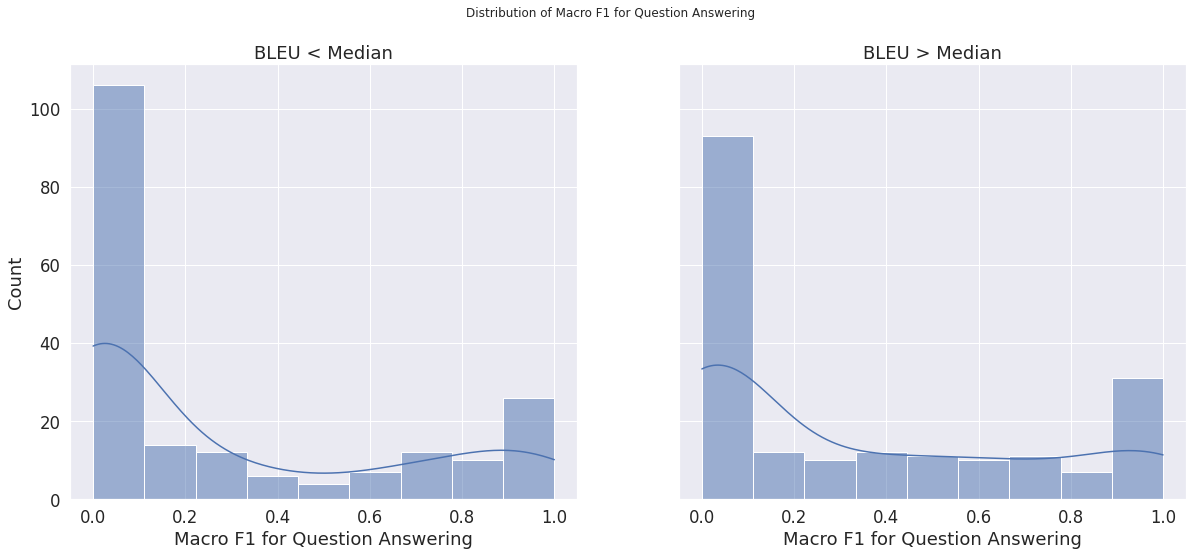

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)

sns.histplot(data=df_main[df_main.bleu < df_main.bleu.median()], x="macroF1", ax=axs[0], kde=True)
axs[0].set(title="BLEU < Median", xlabel="Macro F1 for Question Answering")

sns.histplot(data=df_main[df_main.bleu > df_main.bleu.median()], x="macroF1", ax=axs[1], kde=True)
axs[1].set(title="BLEU > Median", xlabel="Macro F1 for Question Answering")

# set the overall title
plt.suptitle("Distribution of Macro F1 for Question Answering")

# show the plot
plt.show()

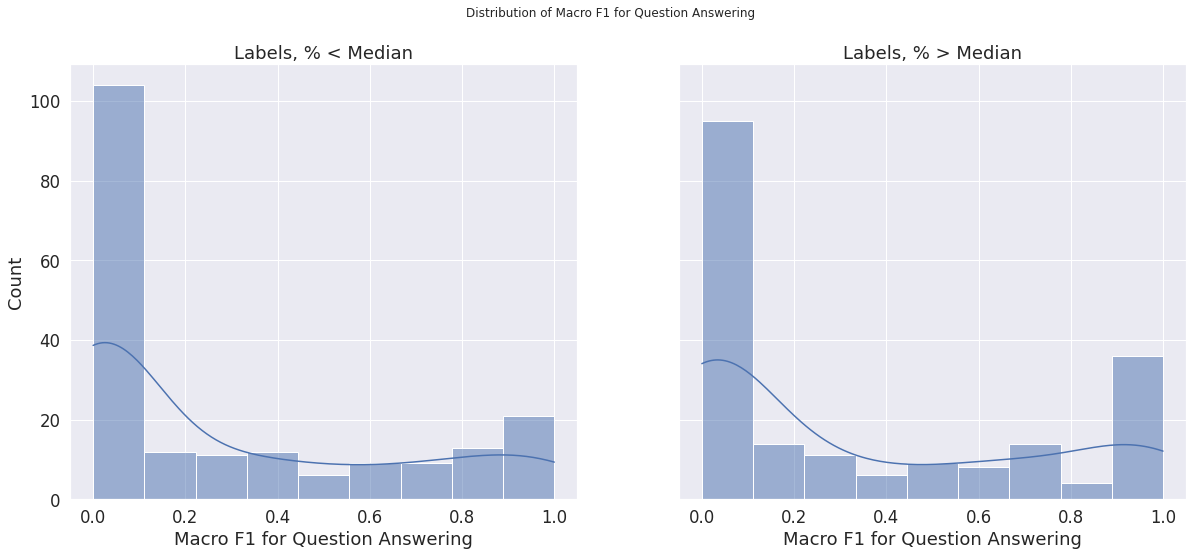

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)

sns.histplot(data=df_main[df_main.labels < df_main.labels.median()], x="macroF1", ax=axs[0], kde=True)
axs[0].set(title="Labels, % < Median", xlabel="Macro F1 for Question Answering")

sns.histplot(data=df_main[df_main.labels > df_main.labels.median()], x="macroF1", ax=axs[1], kde=True)
axs[1].set(title="Labels, % > Median", xlabel="Macro F1 for Question Answering")

# set the overall title
plt.suptitle("Distribution of Macro F1 for Question Answering")

# show the plot
plt.show()

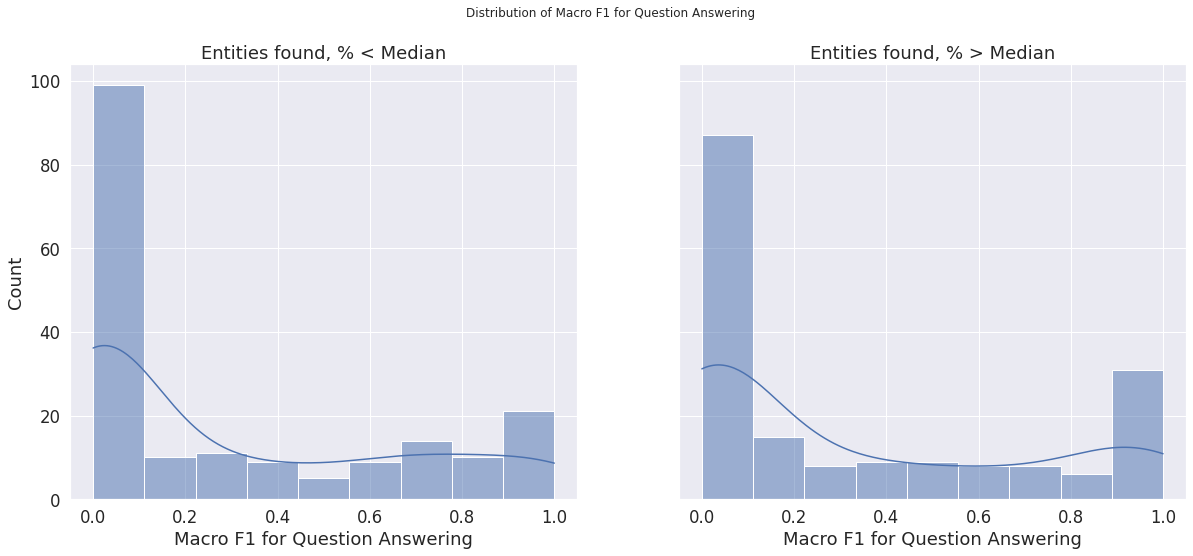

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)

sns.histplot(data=df_main[df_main.entities_found < df_main.entities_found.median()], x="macroF1", ax=axs[0], kde=True)
axs[0].set(title="Entities found, % < Median", xlabel="Macro F1 for Question Answering")

sns.histplot(data=df_main[df_main.entities_found > df_main.entities_found.median()], x="macroF1", ax=axs[1], kde=True)
axs[1].set(title="Entities found, % > Median", xlabel="Macro F1 for Question Answering")

# set the overall title
plt.suptitle("Distribution of Macro F1 for Question Answering")

# show the plot
plt.show()

In [19]:
df_main.corr() # due to the sparce values of macroF1, the correlation may be misleading that's why we use sankey diagrams

,entities_found,bleu,labels,macroF1
entities_found,1.000000,-0.151979,0.369698,-0.072694
bleu,-0.151979,1.000000,-0.046883,-0.017927
labels,0.369698,-0.046883,1.000000,0.084415
macroF1,-0.072694,-0.017927,0.084415,1.000000


In [177]:
# assign a category to a column based on Q1, Q2, Q3, Q4
def category(x, q1, q2, q3, factor=0):
    if x <= q1:
        return 0 + factor
    elif x <= q2:
        return 1 + factor
    elif x <= q3:
        return 2 + factor
    else:
        return 3 + factor

df_main["entities_found_cat"] = df_main.entities_found.apply(lambda x: category(x, df_main.entities_found.quantile(0.25), df_main.entities_found.quantile(0.5), df_main.entities_found.quantile(0.75), 0))
df_main["labels_cat"] = df_main.labels.apply(lambda x: category(x, df_main.labels.quantile(0.25), df_main.labels.quantile(0.5), df_main.labels.quantile(0.75), 4))    
df_main["macroF1_cat"] = df_main.macroF1.apply(lambda x: 8 if x < 1 else 9)
df_main["bleu_cat"] = df_main.bleu.apply(lambda x: category(x, df_main.bleu.quantile(0.25), df_main.bleu.quantile(0.5), df_main.bleu.quantile(0.75), 10))

In [178]:
import itertools
# cartesian product of two lists
entities_found_cat_ids = [0, 1, 2, 3]
labels_cat_ids = [4, 5, 6, 7]
macroF1_cat_ids = [8, 9]
bleu_cat_ids = [10, 11, 12, 13]

pairs = list(itertools.product(labels_cat_ids, macroF1_cat_ids))

values = [0]*len(pairs)
# compute how many respective pairs are in the data


for i, pair in enumerate(pairs):
    values[i] += (len(df[(df_main.labels_cat == pair[0]) & (df_main.macroF1_cat == pair[1])])/len(df_main[df_main.macroF1_cat == pair[1]])) # normalized by target node
    # values[i] += len(df[(df_main.bleu_cat == pair[0]) & (df_main.macroF1_cat == pair[1])])

labels = ["Entities found < Q1", "Entities found < Q2", "Entities found < Q3", "Entities found < Q4", "Labels < Q1", "Labels < Q2", "Labels < Q3", "Labels < Q4", "F1 < 1", "F1 = 1", "BLEU < Q1", "BLEU < Q2", "BLEU < Q3", "BLEU < Q4"]
colors = ["blue", "blue", "blue", "blue", "#135c23", "#135c23", "#135c23", "#135c23", "#ffa600", "#135c23", "#7c8a00", "#7c8a00", "#7c8a00", "#7c8a00", "#7c8a00", "#7c8a00"]
link_colors = ["#ba9b00", "#477416"]*7
# convert colors to rgba with opacity   

In [184]:
df_main.labels.describe()

count    394.000000
mean       0.679582
std        0.320441
min        0.000000
25%        0.476190
50%        0.753968
75%        1.000000
max        1.000000
Name: labels, dtype: float64

In [179]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = colors,
      # x = [0, 0, 0, 0, 0, 1, 1, 1],
      # y = [0, ]
    ),
    link = dict(
      source = [pair[0] for pair in pairs],
      target = [pair[1] for pair in pairs],
      value = values,
      # color = link_colors,
      
  ))])

fig.update_layout(title_text="", font_size=10)
fig.show()
# save figure as html
# fig.write_html(f"sankey_entities_{dataset}_{lang}.html")


## Score comparison

In [241]:
dir_path = "../translated_data/finished_experiments" # or "../translated_data/"
lang = "ru"
dataset = "qald9plustrain"

default_mt = [file for file in os.listdir(dir_path) if ".log" in file and f"{lang}-" in file and dataset in file.lower() and "no_ner-no_el" in file.lower()] 
ner_mt = [file for file in os.listdir(dir_path) if ".log" in file and f"{lang}-" in file and dataset in file.lower() and "no_ner-no_el" not in file.lower()]
plc_ft_mt = [file for file in os.listdir(dir_path) if ".log" in file and f"{lang}-" in file and dataset in file.lower() and "plc_ft" in file.lower()]

In [242]:
macroF1 = []
for file in default_mt:
    df = pd.read_csv(os.path.join(dir_path, file), sep='\t')
    # leave only rows with unique id values
    df = df.drop_duplicates(subset=['id'])
    
    if len(df.columns) > len(standard_columns) and df.macroF1.mean() > 0.0:
        macroF1.append(df.macroF1.astype(float).values.tolist())
        print(file, len(df.macroF1))
default_mt_f1_mean = np.array(macroF1).T.mean(axis=1)

deeppavlov-QALD9PlusTrain-MT-Wikidata_ru-no_ner-no_el-libre_mt.json.json.log 370
deeppavlov-QALD9PlusTrain-MT-Wikidata_ru-no_ner-no_el-opus_mt.json.json.log 370
deeppavlov-QALD9PlusTrain-MT-Wikidata_ru-no_ner-no_el-mbart_plc_ft_mt.json.json.log 370


In [243]:
macroF1 = []
for file in ner_mt:
    df = pd.read_csv(os.path.join(dir_path, file), sep='\t')
    df = df.drop_duplicates(subset=['id'])
    if len(df.columns) > len(standard_columns) and df.macroF1.mean() > 0.0:
        macroF1.append(df.macroF1.astype(float).values.tolist())
        print(file, len(df.macroF1))
ner_mt_f1_mean = np.array(macroF1).T.mean(axis=1)

deeppavlov-QALD9PlusTrain-MT-Wikidata_ru-spacy_ner-mgenre_el-opus_mt.json.json.log 370
deeppavlov-QALD9PlusTrain-MT-Wikidata_ru-spacy_ner-mgenre_el-nllb_mt.json.json.log 370


In [244]:
macroF1 = []
for file in plc_ft_mt:
    df = pd.read_csv(os.path.join(dir_path, file), sep='\t')
    df = df.drop_duplicates(subset=['id'])
    if len(df.columns) > len(standard_columns) and df.macroF1.mean() > 0.0:
        macroF1.append(df.macroF1.astype(float).values.tolist())
        print(file, len(df.macroF1))
plc_ft_mt_f1_mean = np.array(macroF1).T.mean(axis=1)

deeppavlov-QALD9PlusTrain-MT-Wikidata_ru-no_ner-no_el-mbart_plc_ft_mt.json.json.log 370


In [245]:
default_mt_f1_mean.mean(), ner_mt_f1_mean.mean(), plc_ft_mt_f1_mean.mean()

(0.1995270806163933, 0.21911852856768113, 0.1865009150777652)